<a href="https://colab.research.google.com/github/aarontjoseph94/ENEL645-Assignments/blob/TA%2F2-1-3/assignment02.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 02 - CIFAR10 Image Classification

In this assignment your team will design a fully connected neural network and a convolutional neural network (CNN) models for classifiying the CIFAR10 image dataset. The deliverables for the assignment are:

1. This jupyter-notebook completed with your solution. I expect you to try different configurations (models, train/validtion split, etc.), but for your submission, leave just the best fully connected and the best CNN models.
    - Name the notebook as enel645_assignment02_team_(team number).ipynb
2. The weights of your best fully connected neural network model and your best CNN model 
    - Name the weights files as team_(team number)_FCN.h5 (fully connected model) and team_(team number)_FCN.h5 (CNN model)

Submit the three files (notebook + models' weights) to your dropbox in the course D2L page.
    
We will be using the CIFAR10 dataset. The dataset alerady comes with a test set and you shouldn't change it. It is up to you to determine how to split your development set into training and validation sets. Use variable names consistent with the variables pre-filled in this document.


You are free to add extra cells of text and code to this notebook.

At the end of the notebook, please include a short description of what each team member did in the assignment. Also include the consensus score between 0 and 3 to each team member. This score will be used to adjust the final 
grade of each student. Students developing the project individually do not need this description and score.

You are being assessed based on:

1. Code execution - 20% 
2. Clarity of the code (e.g., easy to follow, has pertinent comments, etc.) - 20%
3. Proper usage of the techniques seen in class - 30% 
4. Accuracy of the models  - 30%


In [1]:
import matplotlib.pylab as plt
import numpy as np
import tensorflow as tf

In [2]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

## 1. Load your data

In [3]:
(X_dev, Y_dev), (X_test, Y_test) = tf.keras.datasets.cifar10.load_data()

print(X_dev.shape)
print(X_test.shape)

170500096/170498071 [==============================] - 4s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


## 2. Explore your data 

In [4]:
# Use this space to explore you datasets
# Create additional cells as you see fit
# Let's shuffle the samples and split them
indexes = np.arange(X_dev.shape[0], dtype = int)
np.random.shuffle(indexes)
X_dev = X_dev[indexes]
Y_dev = Y_dev[indexes]

nsplit = int(0.75*X_dev.shape[0]) 

# Train and validation split
X_train = X_dev[:nsplit]
Y_train = Y_dev[:nsplit]
X_val = X_dev[nsplit:]
Y_val = Y_dev[nsplit:]

## 3. Represent your labels using one hot encoding

In [5]:
from tensorflow.keras.utils import to_categorical
Y_train_oh = to_categorical(Y_train)
Y_val_oh = to_categorical(Y_val)
Y_test_oh = to_categorical(Y_test)

## 4. Data scaling and Data augmentation

In [6]:
# Experiment with different data scaling methods
norm_type = 1 # 0 -> min-max; 1-> standardization

if norm_type == 0:
    X_train = X_train/255
    X_val = X_val/255
    X_test = X_test/255
elif norm_type == 1:
    train_mean, train_std = X_train.mean(),X_train.std() 
    X_train = (X_train - train_mean)/train_std
    X_val = (X_val - train_mean)/train_std
    X_test = (X_test - train_mean)/train_std
else:
    pass
# Create your data augmentation object to improve training
# set your batch size
batch_size = 32
gen_params = {"featurewise_center":False,"samplewise_center":False,"featurewise_std_normalization":False,\
              "samplewise_std_normalization":False,"zca_whitening":False,"rotation_range":20,"width_shift_range":0.1,"height_shift_range":0.1,\
              "shear_range":0.2, "zoom_range":0.1,"horizontal_flip":True,"fill_mode":'constant',\
               "cval": 0}
train_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(gen_params)

train_gen.fit(X_train,seed = 1)
val_gen.fit(X_val, seed = 1)

train_flow = train_gen.flow(X_train,Y_train_oh,batch_size = batch_size)
val_flow = val_gen.flow(X_val,Y_val_oh,batch_size = batch_size)

## Fully Connected Model

## 5. Define your  model, cost function, optimizer, learning rate

In [7]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
def my_model_fully_connected(ishape=(32, 32, 3), k=10, lr=1e-4, drop=0.2):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_input_flatten = tf.keras.layers.Flatten()(model_input)
    model_dense_1 = tf.keras.layers.Dense(512, activation='relu')(model_input_flatten)
    model_drop_1 = tf.keras.layers.Dropout(rate=drop)(model_dense_1)
    model_dense_2 = tf.keras.layers.Dense(512, activation='relu')(model_drop_1)
    model_drop_2 = tf.keras.layers.Dropout(rate=drop)(model_dense_2)
    out = tf.keras.layers.Dense(k,activation = 'softmax')(model_drop_2)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

## 6. Define your callbacks (save your model, patience, etc.)

In [17]:
model_name_fcn = "team_48_FCN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_fcn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [19]:
model = my_model_fully_connected()
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               1573376   
_________________________________________________________________
dropout_4 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 512)               262656    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                5130

In [20]:
# train your model - decide for how many epochs
model.fit(train_flow, epochs = 40, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/40
1172/1172 [==============================] - 21s 18ms/step - loss: 1.9725 - accuracy: 0.3218 - val_loss: 1.5751 - val_accuracy: 0.4422
Epoch 2/40
1172/1172 [==============================] - 21s 18ms/step - loss: 1.5913 - accuracy: 0.4430 - val_loss: 1.4882 - val_accuracy: 0.4772
Epoch 3/40
1172/1172 [==============================] - 21s 18ms/step - loss: 1.4981 - accuracy: 0.4764 - val_loss: 1.4516 - val_accuracy: 0.4916
Epoch 4/40
1172/1172 [==============================] - 21s 18ms/step - loss: 1.3991 - accuracy: 0.5056 - val_loss: 1.4193 - val_accuracy: 0.5013
Epoch 5/40
1172/1172 [==============================] - 21s 18ms/step - loss: 1.3157 - accuracy: 0.5387 - val_loss: 1.3637 - val_accuracy: 0.5254
Epoch 6/40
1172/1172 [==============================] - 21s 18ms/step - loss: 1.2498 - accuracy: 0.5631 - val_loss: 1.3606 - val_accuracy: 0.5252
Epoch 7/40
1172/1172 [==============================] - 21s 18ms/step - loss: 1.2239 - accuracy: 0.5744 - val_loss: 1.3429 -

## 8. Test your model

313/313 [==============================] - 2s 7ms/step - loss: 1.3171 - accuracy: 0.5480


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


4520


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

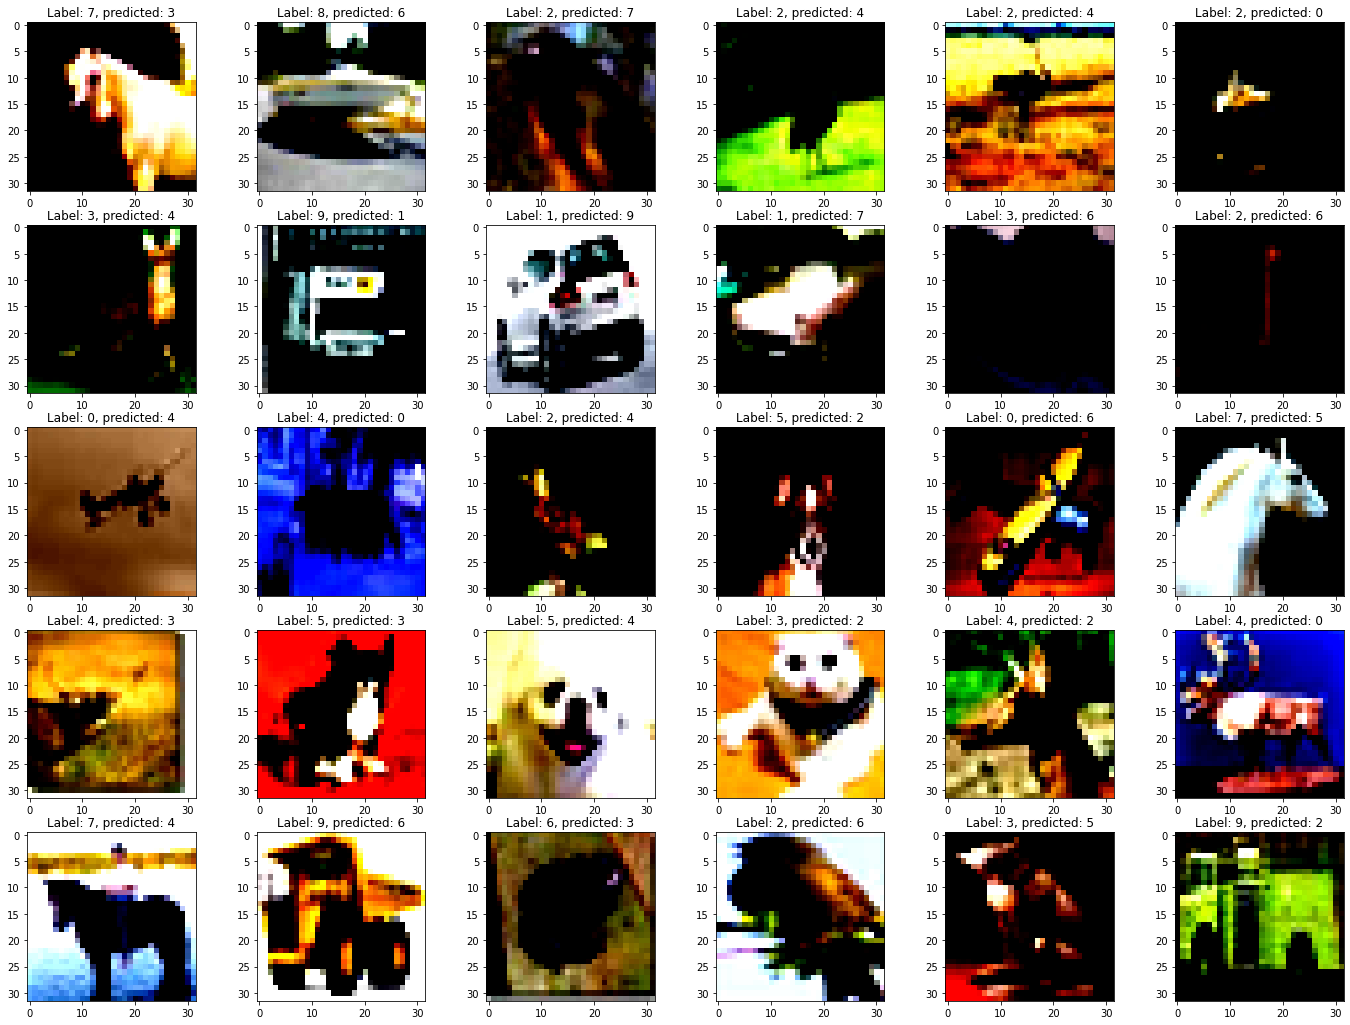

In [21]:
model.load_weights(model_name_fcn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

## Convolutional Model

## 5. Define your  model, cost function, optimizer, learning rate

In [31]:
# Define your model here. Include accuracy in the metrics list when you compile it
# Experiment with different network architectures, learnig rates, dropout, etc.
# VGG-16 inspired model, with 4 convolutional layer groups
def my_model_cnn(ishape=(32, 32, 3), d=1, k=10, lr=1e-3, drop=0.1):
    model_input = tf.keras.layers.Input(shape = ishape)
    model_conv_0 = tf.keras.layers.Conv2D(32, 2, activation='relu', dilation_rate=d, padding='same')(model_input)
    model_pooling_0 = tf.keras.layers.MaxPool2D()(model_conv_0)
    model_conv_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', dilation_rate=d, padding='same')(model_pooling_0)
    model_pooling_1 = tf.keras.layers.MaxPool2D()(model_conv_1)
    model_conv_2 = tf.keras.layers.Conv2D(128, 3, activation='relu', dilation_rate=d, padding='same')(model_pooling_1)
    model_pooling_2 = tf.keras.layers.MaxPool2D()(model_conv_2)
    model_conv_3 = tf.keras.layers.Conv2D(256, 3, activation='relu', dilation_rate=d, padding='same')(model_pooling_2)
    model_pooling_3 = tf.keras.layers.MaxPool2D(pool_size=(4,4))(model_conv_3)
    model_conv_flatten = tf.keras.layers.Flatten()(model_pooling_3)
    model_dense_1 = tf.keras.layers.Dense(256, activation='relu')(model_conv_flatten)
    model_drop_1 = tf.keras.layers.Dropout(rate=drop)(model_dense_1)
    model_dense_2 = tf.keras.layers.Dense(256, activation='relu')(model_drop_1)
    model_drop_2 = tf.keras.layers.Dropout(rate=drop)(model_dense_2)
    out = tf.keras.layers.Dense(k, activation='softmax')(model_drop_2)
    model = tf.keras.models.Model(inputs = model_input, outputs = out)
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), loss='categorical_crossentropy', metrics = ["accuracy"])
    return model

## 6. Define your callbacks (save your model, patience, etc.)

In [34]:
model_name_cnn = "team_48_CNN.h5"

# define your callbacks
# remember that you need to save the weights of your best model!
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience = 20)

monitor = tf.keras.callbacks.ModelCheckpoint(model_name_cnn, monitor='val_loss',\
                                             verbose=0,save_best_only=True,\
                                             save_weights_only=True,\
                                             mode='min')
# Learning rate schedule
def scheduler(epoch, lr):
    if epoch%4 == 0 and epoch!= 0:
        lr = lr/2
    return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler,verbose = 0)

## 7. Train your model

In [35]:
model = my_model_cnn()
model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 32, 32, 32)        416       
_________________________________________________________________
max_pooling2d_15 (MaxPooling (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 16, 16, 64)        18496     
_________________________________________________________________
max_pooling2d_16 (MaxPooling (None, 8, 8, 64)          0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 8, 8, 128)         73856     
_________________________________________________________________
max_pooling2d_17 (MaxPooling (None, 4, 4, 128)         0   

In [36]:
# train your model - decide for how many epochs
model.fit(train_flow, epochs = 20, \
          verbose = 1, callbacks= [early_stop, monitor, lr_schedule],validation_data=(val_flow))

Epoch 1/20
1172/1172 [==============================] - 161s 137ms/step - loss: 1.7219 - accuracy: 0.3585 - val_loss: 1.0734 - val_accuracy: 0.6111
Epoch 2/20
1172/1172 [==============================] - 162s 138ms/step - loss: 1.0538 - accuracy: 0.6273 - val_loss: 0.9159 - val_accuracy: 0.6795
Epoch 3/20
1172/1172 [==============================] - 164s 140ms/step - loss: 0.8270 - accuracy: 0.7092 - val_loss: 0.8771 - val_accuracy: 0.7019
Epoch 4/20
1172/1172 [==============================] - 164s 140ms/step - loss: 0.6566 - accuracy: 0.7704 - val_loss: 0.7985 - val_accuracy: 0.7247
Epoch 5/20
1172/1172 [==============================] - 159s 136ms/step - loss: 0.4565 - accuracy: 0.8416 - val_loss: 0.7983 - val_accuracy: 0.7390
Epoch 6/20
1172/1172 [==============================] - 157s 134ms/step - loss: 0.3238 - accuracy: 0.8897 - val_loss: 0.8428 - val_accuracy: 0.7362
Epoch 7/20
1172/1172 [==============================] - 156s 133ms/step - loss: 0.2451 - accuracy: 0.9148 - val_

## 8. Test your model

313/313 [==============================] - 8s 26ms/step - loss: 0.8128 - accuracy: 0.7350


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

2650


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

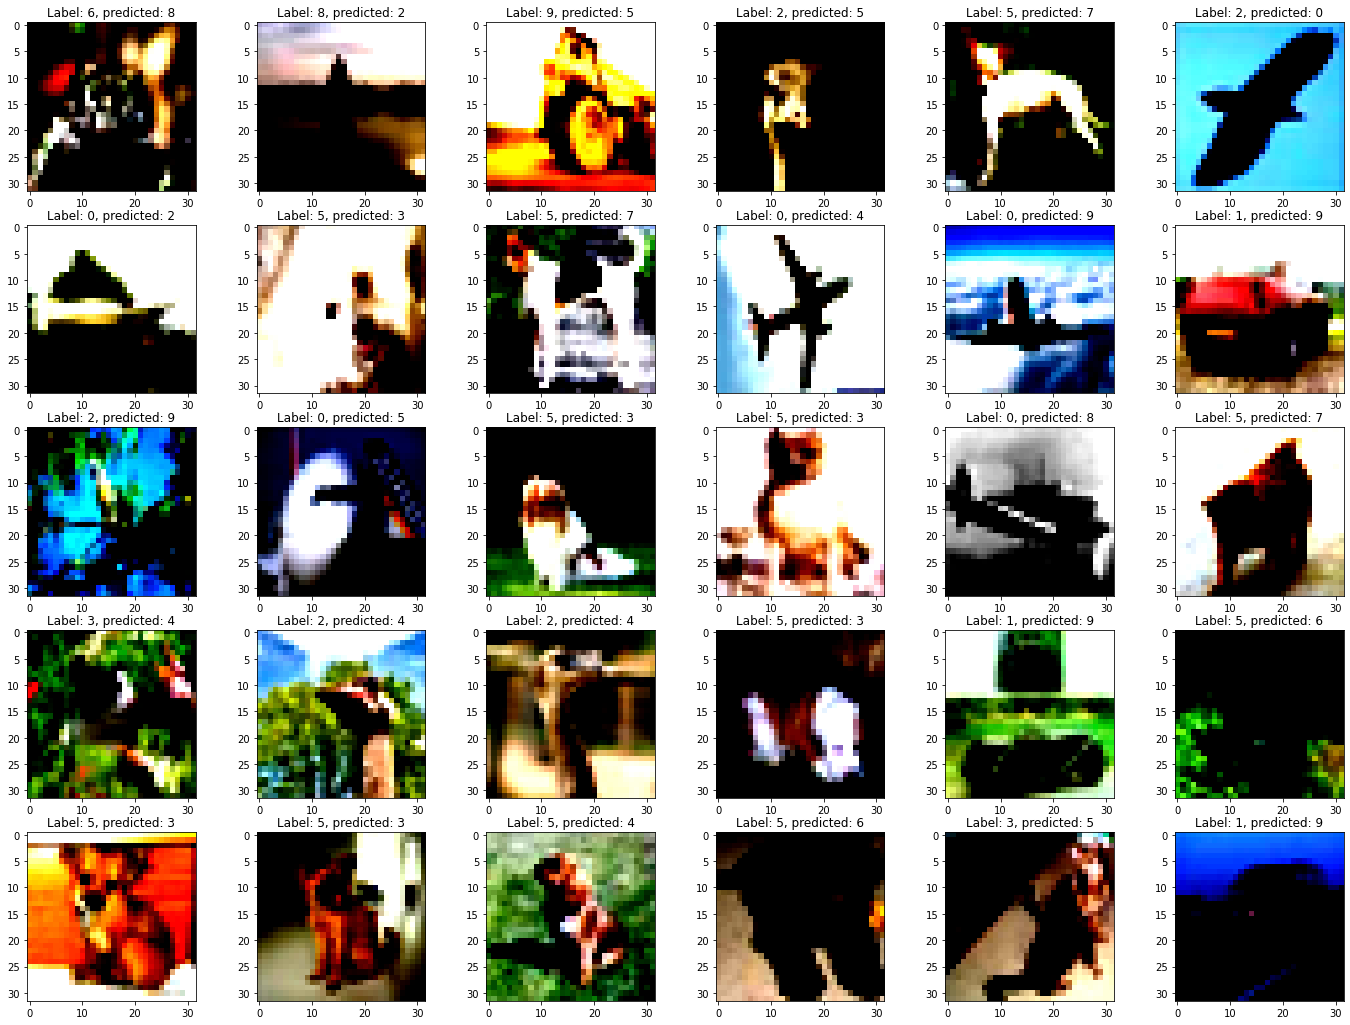

In [37]:
model.load_weights(model_name_cnn)
metrics = model.evaluate(X_test,Y_test_oh)

Ypred = model.predict(X_test).argmax(axis = 1)
wrong_indexes = np.where(Ypred != Y_test[:,0])[0]
print(wrong_indexes.size)

# Disaplying some samples from the development set
sample_indexes = np.random.choice(np.arange(wrong_indexes.shape[0], dtype = int),size = 30, replace = False)
plt.figure(figsize = (24,18))
for (ii,jj) in enumerate(sample_indexes):
    plt.subplot(5,6,ii+1)
    plt.imshow(X_test[wrong_indexes[jj]], cmap = "gray")
    plt.title("Label: %d, predicted: %d" %(Y_test[wrong_indexes[jj]],Ypred[wrong_indexes[jj]]))
plt.show()

##  Team members participtaion
(include the description of what each team member did and the consensus score for each team member)

- **Do Trong Anh, Bright Anorchie, Aaron Joseph, Alan Joseph** helped design the model and write the code for fully connected model (**score 3**)
- **Do Trong Anh, Bright Anorchie, Aaron Joseph, Alan Joseph** helped design helped to implement the data augmentation module (**score 3**)